## Aim

Given a vector file (geojson or other), the exact tile grid IDs of Sentinel 2 that intersect with it are obtained.

The tiling grid in geojson can be found on [Zenodo](https://zenodo.org/records/10998972).

The code below is run in Google Colab.

## Importing the Python packages

In [2]:
from pathlib import Path
from typing import List, Literal

import folium
import geopandas as gpd
from geopandas import GeoDataFrame as GDF

## Reading in the data

The geojson file of two cities, Bangalore and Chennai, is imported here. The data for Chennai and Bangalore are obtained from OpenCity and are cleaned up using [this script](https://github.com/EllenB/eopf/blob/main/convert_kml_geojson.ipynb).

Change the code below for your path. Alternatively, you can also upload the code in Colab.

In [3]:
## root path
root_path = 'https://github.com/EllenB/eopf/releases/download/data/'


In [4]:
file_bangalore = 'bangalore_boundary.geojson'
## file_chennai =

In [5]:
bang_link = root_path + file_bangalore
bang_link

'https://github.com/EllenB/eopf/releases/download/data/bangalore_boundary.geojson'

In [6]:
!wget -O bang_boundary.geojson \
$bang_link

--2026-02-03 04:37:19--  https://github.com/EllenB/eopf/releases/download/data/bangalore_boundary.geojson
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/1146031685/4178bf08-a682-4e70-b827-afff8657259d?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-02-03T05%3A21%3A35Z&rscd=attachment%3B+filename%3Dbangalore_boundary.geojson&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2026-02-03T04%3A20%3A49Z&ske=2026-02-03T05%3A21%3A35Z&sks=b&skv=2018-11-09&sig=FSZSwk4TyepzfbeUUjJtuN24CCWhnlsyFK5deiqebJc%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc3MDA5MzczOSwibmJmIjoxNzcwMDkzNDM5LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZ

<Axes: >

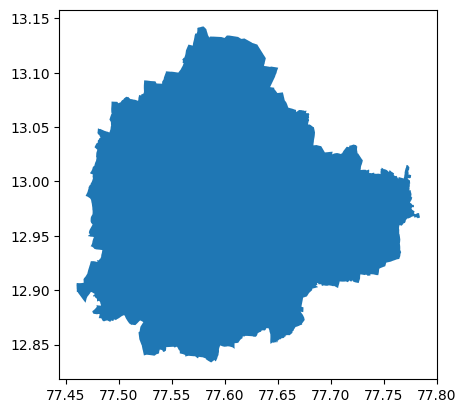

In [7]:
bang_gdf = gpd.read_file('/content/bang_boundary.geojson')
bang_gdf.plot()

The geojson of the Sentinel 2 tile grid:

In [8]:
path_s2_grid = root_path + 'sentinel2_tiling_grid_wgs84.geojson'

In [9]:
s2_grid = gpd.read_file(path_s2_grid)

In [10]:
s2_grid.head()

,Name,geometry
0,01CCV,"MULTIPOLYGON Z (((180 -73.05974 0, 176.86462 -..."
1,01CCV,"MULTIPOLYGON Z (((-180 -72.07333 0, -179.62744..."
2,01CDH,"MULTIPOLYGON Z (((180 -83.80855 0, 174.71288 -..."
3,01CDH,"MULTIPOLYGON Z (((-180 -82.8259 0, -176.29744 ..."
4,01CDJ,"MULTIPOLYGON Z (((180 -82.91344 0, 175.74819 -..."


In [11]:
print(f'There are {s2_grid.shape[0]} tiles in the Sentinel 2 tile grid')

There are 56984 tiles in the Sentinel 2 tile grid


## Function to extract tile ID

Next, a function is defined that given a geopandas dataframe the Sentinel 2 tiles the dataframe intersects with is given.

In [12]:
def extract_s2_tiles(
    aoi_gdf: GDF,
    tiles_gdf: GDF,
    predicate: Literal["within", "intersects"] = "within"
  ) -> List[str]:
  """
  Extract Sentinel-2 tile IDs related to an AOI.

  Parameters
  ----------
  aoi_gdf : GeoDataFrame
        GeoDataFrame of the AOI.
  tiles_gdf : GeoDataFrame
        GeoDataFrame of the Sentinel-2 tile grid.

  Returns
  -------
  List[str]
        List of tile IDs that intersect the AOI.

  """
  ## Check for same crs
  if aoi_gdf.crs != tiles_gdf.crs:
        print(f'CRS mismatch detected! Reprojecting AOI from {aoi_gdf.crs} to {tiles_gdf.crs}')
        aoi_gdf = aoi_gdf.to_crs(tiles_gdf.crs)

  polys_in_polys = gpd.sjoin(aoi_gdf, tiles_gdf, predicate=predicate, how='left')
  return polys_in_polys['Name'].to_list()

## Examples for extracting tiles

In [13]:
tiles_bang_within = extract_s2_tiles(bang_gdf, s2_grid)
print(f'The area of interest falls in the following Sentinel 2 tiles: {tiles_bang_within}')

The area of interest falls in the following Sentinel 2 tiles: ['43PGQ']


In [14]:
tiles_bang_intersects = extract_s2_tiles(bang_gdf, s2_grid, predicate = 'intersects')
print(f'The area of intersects with the following Sentinel 2 tiles: {tiles_bang_intersects}')

The area of intersects with the following Sentinel 2 tiles: ['43PHQ', '43PGQ']


## Folium plots

### Bangalore

In [15]:
def extract_center_lat_lon(gdf:GDF) -> list[float, float]:
  """
  Extract the center point in latitude and longitude of a given a given
  geopandas dataframe

  Parameters
  ----------
  gdf : GeoDataFrame
    GeoDataFrame in EPSG:4326.

  Returns
  -------
  Tuple[float, float]
      (latitude, longitude) of the center.
  """
  minx, miny, maxx, maxy = gdf.total_bounds

  lon_center = (minx + maxx) / 2
  lat_center = (miny + maxy) / 2

  return [lat_center, lon_center]


Initiate the map:

In [16]:
center = extract_center_lat_lon(bang_gdf)
print(center)

[np.float64(12.9880550526928), np.float64(77.62197179945835)]


In [ ]:
m = folium.Map(center, zoom_start=7)
m

In [18]:
def extract_gdf_tiles(
    gdf:GDF,
    list_tiles: List
) -> GDF:
  gdf_tiles_short = gdf[gdf['Name'].isin(list_tiles)]
  return gdf_tiles_short

In [19]:
tiles_chennai = extract_gdf_tiles(s2_grid, tiles_bang_intersects)
tiles_chennai

,Name,geometry
40564,43PGQ,"MULTIPOLYGON Z (((76.8479 13.56161 0, 77.86187..."
40573,43PHQ,"MULTIPOLYGON Z (((77.77159 13.55307 0, 78.7847..."


In [ ]:
bordersStyle = {
    "color": "blue",
    "weight": 1,
    "fillColor": "pink",
    "fillOpacity": 0.05,
}

m = folium.Map(location=center, zoom_start=9)

folium.GeoJson(
    bang_gdf,
    name="Bangalore AOI",
    style_function=lambda _: {
        "color": "black",
        "weight": 2,
        "fillOpacity": 0.1,
    },
).add_to(m)

folium.GeoJson(
    tiles_chennai,
    name="Sentinel-2 tiles",
    style_function=lambda _: bordersStyle,
    tooltip=folium.GeoJsonTooltip(fields=["Name"]),
).add_to(m)

folium.LayerControl().add_to(m)
m


One can see that Bangalore is fully  within the tile **43PQG**.

Since the code is commented in the past few cells (as this is better to upload less big files in Github), you can find some images here. The left one shows how you can toggle between the geojson of Bangalore and the layers for the two tiles for which there is an overlap with the Bangalore geometry.

In [30]:
from IPython.display import Image, display, HTML

url1 = "https://raw.githubusercontent.com/EllenB/eopf/main/images/bangalore_folium.JPG"
url2 = "https://raw.githubusercontent.com/EllenB/eopf/main/images/bangalore_folium_2.JPG"  # replace if needed

display(HTML(f"""
<div style="display:flex; gap:20px;">
  <img src="{url1}" width="500">
  <img src="{url2}" width="500">
</div>
"""))


### Chennai

## References

https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html

https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson.html#styling

https://python-visualization.github.io/folium/latest/user_guide/geojson/geojson_popup_and_tooltip.html

[Sentinel-2 Tiling Grid (WGS84) in geojson format](https://zenodo.org/records/10998972)